<a href="https://colab.research.google.com/github/lauraosede/CE888/blob/main/Lab_8/TL_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
os.environ['KAGGLE_USERNAME'] = "lauraosede" # username from the json file
os.environ['KAGGLE_KEY'] = "7d2ff1d844dbe8e88a5721c6f2bacae8" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle (https://www.kaggle.com/c/dogs-vs-cats/data)



  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.4MB/s]
 97% 526M/543M [00:04<00:00, 135MB/s]
100% 543M/543M [00:04<00:00, 133MB/s]
 98% 265M/271M [00:04<00:00, 73.9MB/s]
100% 271M/271M [00:04<00:00, 64.5MB/s]


In [6]:
from zipfile import ZipFile
file_name = "/content/train.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')



# Get all the paths
data_dir_list = os.listdir('/content/train')
#print(data_dir_list)
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print(file_count)

done
25000


In [7]:
# Make new base directory
original_dataset_dir = '/content/train'
base_dir = '/content/cats_and_dogs_small'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [8]:
import shutil
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [9]:
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [10]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'dog': return 1
    elif word_label == 'cat': return 0

In [11]:
import cv2
def createDataSplitSet(datapath):
    X=[]
    y=[]
    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)
    return np.array(X), np.array(y)

In [12]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

(2000, 224, 224, 3)
(1000, 224, 224, 3)
(1000, 224, 224, 3)


In [13]:
## VGG 16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [14]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [15]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(1, activation='sigmoid', name='output')(x)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-3]:
	layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [18]:
history = model.fit(train_X, train_y,
                              batch_size=20,
                              epochs=20, 
                              validation_data=(val_X, val_y),
                              callbacks=my_callbacks)

Epoch 1/20
100/100 [==============================] - 27s 88ms/step - loss: 0.5784 - acc: 0.7598 - val_loss: 0.2025 - val_acc: 0.9140
Epoch 2/20
100/100 [==============================] - 8s 83ms/step - loss: 0.1006 - acc: 0.9628 - val_loss: 0.3853 - val_acc: 0.8500
Epoch 3/20
100/100 [==============================] - 8s 82ms/step - loss: 0.0671 - acc: 0.9788 - val_loss: 0.1848 - val_acc: 0.9280
Epoch 4/20
100/100 [==============================] - 8s 83ms/step - loss: 0.0135 - acc: 0.9982 - val_loss: 0.3546 - val_acc: 0.8910
Epoch 5/20
100/100 [==============================] - 8s 83ms/step - loss: 0.0178 - acc: 0.9954 - val_loss: 0.6680 - val_acc: 0.8500
Epoch 6/20
100/100 [==============================] - 8s 82ms/step - loss: 0.0277 - acc: 0.9880 - val_loss: 0.3279 - val_acc: 0.9150
Epoch 7/20
100/100 [==============================] - 8s 82ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.2739 - val_acc: 0.9190
Epoch 8/20
100/100 [==============================] - 8s 82ms/step -

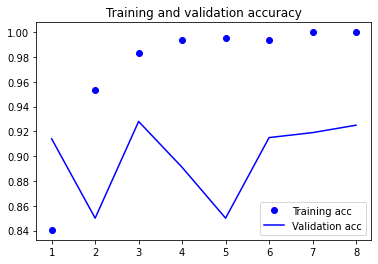

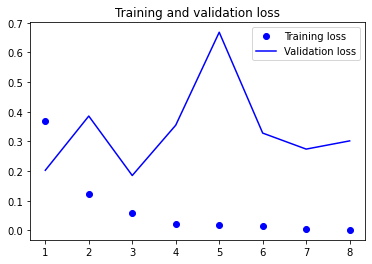

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 1.0
Val Accuracy:	 0.925000011920929
Test Accuracy:	 0.92
Precision:	 0.9166666666666666
Recall:		 0.924
F1 Score:	 0.9203187250996016
AUC:		 0.9199999999999999


# Implementing fine tuning on image dataset

imports

In [21]:
%matplotlib inline

import os
import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

Data

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# Make new base directory
original_dataset_dir = '/content/drive/MyDrive/data science /ds/data/comb'
base_dir_ft = '/content/drive/MyDrive/data science /ds/data/cats_dogs_horses_human'
#os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

In [45]:
import shutil
#cats
fnames = ['cat.{}.jpg'.format(i) for i in range(1, 100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(100,150)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(150,200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

#dogs
fnames = ['dog.{}.jpg'.format(i) for i in range(1,100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(100,150)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(150, 200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)


#humans
fnames = ['rider-{}.jpg'.format(i) for i in range(1, 100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname, )
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['rider-{}.jpg'.format(i) for i in range(100 - 150)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['rider-{}.jpg'.format(i) for i in range(150, 200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

#horses
fnames = ['horse-{}.jpg'.format(i) for i in range(1 - 100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['horse-{}.jpg'.format(i) for i in range(100, 150)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['horse-{}.jpg'.format(i) for i in range(150, 200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [46]:
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [47]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'dog': return 1
    elif word_label == 'cat': return 0

In [48]:
import cv2
def createDataSplitSet(datapath):
    X=[]
    y=[]
    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)
    return np.array(X), np.array(y)

In [49]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

(2099, 224, 224, 3)
(1150, 224, 224, 3)
(1200, 224, 224, 3)


Fine-tuning using the ResNet50 model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras

In [ ]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

### Fine tuning using resnet50 

In [50]:
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import ResNet50

In [51]:
conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=(224, 224, 3))

print(conv_base.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [52]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 30,010,434
Trainable params: 29,957,314
Non-trainable params: 53,120
_______________________________________

In [53]:
# Make the conv_base NOT trainable:

for layer in conv_base.layers[:]:
   layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


In [54]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [55]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [56]:
print("model compiled")
print(model.summary())

model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 30,010,434
Trainable params: 6,422,722
Non-trainable params: 23,587,712
_____________________

In [ ]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [ ]:
history = model.fit(train_X, train_y,
                              batch_size=20,
                              epochs=20, 
                              validation_data=(val_X, val_y),
                              steps_per_epoch = 100, 
                              callbacks=my_callbacks)